# Preparing environment

In [5]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir,os.pardir)
src_dir = os.path.join(root_dir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)
    
import math
import copy as cp
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,Birch,AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn import preprocessing

from scipy.cluster import hierarchy
from scipy import stats
from scipy.stats import mstats

import helpers as hlp
%aimport helpers

%aimport external.holtwinters
from external import kMedoids
from IPython.display import display

#printing
pd.options.display.float_format = '{:,.2f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load preprocessed data

In [49]:
raw_path = os.path.join(root_dir,"data\\raw\\")
interim_path = os.path.join(root_dir,"data\\interim\\") 
processed_path = os.path.join(root_dir,"data\\processed\\") 

reports_path = os.path.join(root_dir,"reports\\")
models_path = os.path.join(root_dir,"models\\")

raw_file_name ="bnd_product_p2c4_raw.csv"
clean_file_name = "bnd_product_p2c4_clean.csv"
z_file_name ="bnd_product_z_p2c4_clean.csv"
clean_full_file_name = "bnd_product_p2c4_clean_full.csv"

clusters_file_name = "euc_p2c4_clustering_clean_week_v6.csv"
client_desc = "data_client_bnd_ita2.csv"

row_headers = ['Product',"Client"]
n_row_headers = len(row_headers)



product_raw_df = pd.read_csv(interim_path+raw_file_name, sep=';', encoding='utf-8')
product_df = pd.read_csv(interim_path+clean_file_name, sep=';', encoding='utf-8')
product_df_full = pd.read_csv(processed_path+z_file_name, sep=';', encoding='utf-8')
product_df_clean = pd.read_csv(interim_path+clean_full_file_name, sep=';', encoding='utf-8')

X_z = product_df_full.values[:,n_row_headers:].astype(np.float64)



nb_col = X_z.shape[1]
X_pca = PCA(n_components = nb_col).fit_transform(X_z)

print(product_df_full.shape)
product_df_clean.head()

(2846, 99)


,Product,Client,2016-01-10 00:00:00,2016-01-17 00:00:00,2016-01-24 00:00:00,2016-01-31 00:00:00,2016-02-07 00:00:00,2016-02-14 00:00:00,2016-02-21 00:00:00,2016-02-28 00:00:00,...,2017-10-01 00:00:00,2017-10-08 00:00:00,2017-10-15 00:00:00,2017-10-22 00:00:00,2017-10-29 00:00:00,2017-11-05 00:00:00,2017-11-12 00:00:00,2017-11-19 00:00:00,2017-11-26 00:00:00,2017-12-03 00:00:00
0,GBA001BND060SS,68A139,4.71,4.29,4.71,5.14,4.14,4.57,4.71,5.00,...,2.29,1.71,2.14,1.86,2.29,2.14,1.71,3.00,2.57,0.00
1,GBA001BND060SS,68C120,8.57,13.71,11.86,6.29,6.29,6.14,6.29,5.14,...,7.86,9.71,19.29,17.29,9.00,8.00,7.14,0.00,0.00,0.00
2,GBA001BND060SS,68C122,3.71,0.86,0.43,0.14,0.29,0.29,1.00,0.43,...,1.29,1.29,1.29,1.29,1.00,1.29,1.00,0.00,0.00,0.00
3,GBA001BND060SS,68C126,1.14,1.29,0.86,1.43,2.86,1.29,1.57,1.86,...,0.29,0.14,0.29,0.43,0.71,0.29,0.71,0.00,0.00,0.00
4,GBA001BND060SS,68C129,1.14,0.71,0.86,1.14,1.14,1.14,1.43,0.86,...,0.86,1.29,1.29,1.29,1.00,1.00,0.57,0.00,0.00,0.00


In [50]:
clusters = pd.read_csv(models_path+clusters_file_name, sep=';', encoding='utf-8').drop('Unnamed: 0',axis=1).drop(["Centroid"],axis=1)#
products = product_df_clean.set_index(['Product','Client'])


clients = pd.read_csv(raw_path+client_desc, sep=';', encoding='iso8859_2').fillna("NA")[["Key_lvl4","Key_lvl5"]].drop_duplicates().set_index("Key_lvl4")

    
keys = pd.merge(clusters,clients,how="inner",left_on=["Client"],right_index=True).set_index(['Product','Client'])
keys = clusters.set_index(['Product','Client'])


series = products.join(keys,how="inner")

#rearange columns
#series = series[['Key_lvl5','Cluster'] + [c for c in series if c not in ['Cluster','Key_lvl5']]]
series = series[['Cluster'] + [c for c in series if c not in ['Cluster']]]

print(series.shape)
series.head()

group_series = series.groupby(['Cluster']).sum().astype(int)

group_series.head()

(2846, 101)


,2016-01-10 00:00:00,2016-01-17 00:00:00,2016-01-24 00:00:00,2016-01-31 00:00:00,2016-02-07 00:00:00,2016-02-14 00:00:00,2016-02-21 00:00:00,2016-02-28 00:00:00,2016-03-06 00:00:00,2016-03-13 00:00:00,...,2017-10-01 00:00:00,2017-10-08 00:00:00,2017-10-15 00:00:00,2017-10-22 00:00:00,2017-10-29 00:00:00,2017-11-05 00:00:00,2017-11-12 00:00:00,2017-11-19 00:00:00,2017-11-26 00:00:00,2017-12-03 00:00:00
Cluster,,,,,,,,,,,,,,,,,,,,,
1,401,467,422,520,466,219,253,286,283,506,...,350,422,224,232,179,193,192,107,134,19
2,97,103,66,36,37,36,46,296,379,109,...,37,130,94,27,15,13,10,10,11,2
3,371,276,119,507,515,148,128,128,101,523,...,498,466,476,170,122,116,743,183,168,21
4,1076,1185,491,278,251,1624,1366,451,1354,1260,...,173,139,703,678,219,154,161,125,268,84
5,281,286,256,298,298,338,290,322,324,332,...,393,311,328,429,311,288,249,143,211,34


## Holt-Winter's Models

In [7]:
import statsmodels.tsa.api as sm
import external.holtwinters as hw
from math import sqrt



def MASE_analysis(mase,**kwargs):    
    plt.figure(figsize=(16,5))
    plt.suptitle(kwargs["title"])
    plt.subplot(1,2,1)
    plt.bar(np.arange(n_clusters)+1,MASE)
    plt.subplot(1,2,2)
    plt.boxplot(mase)
    plt.axhline(y=1,c='lightsalmon',ls='--')


seasonality = [52]
fc=20

n_clusters = group_series.shape[0]

def grid_forecast(series,seasonality_length,forecast):
    preds = []
    errors = np.zeros((len(seasonality_length)))
    for i,m in enumerate(seasonality_length):
        dexp,a,b,g,rmse = hw.additive(list(series[:-forecast]),m,forecast)
        preds.append(dexp)
        errors[i] = rmse
    min_error = np.argmin(errors)
    return preds[min_error],seasonality_length[min_error]

L = 5
take = np.random.randint(1,n_clusters,size = 3*L+1)


plt.figure(figsize=(16,L*3))
forecasts = np.zeros((n_clusters,fc)).astype(np.float64)
MASE = []
RMSE = []

i=1
for cluster,serie in group_series[:].iterrows():
    #winsorizing series
    serie = pd.DataFrame(serie).apply(mstats.winsorize,limits = (None,0.1)).values  
    #days to forecast
    l=len(serie) 

    pred,m = grid_forecast(serie,seasonality,fc)
    
    forecasts[cluster-1] = pred

    rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(serie[-fc:], pred)]) / fc)
    
    train_series = np.ravel(serie[:-fc])
    mase = hw.MASE(train_series,serie[-fc:],pred,m)
    MASE.append(mase)
    RMSE.append(rmse)
    
    if cluster not in take: continue
    plt.subplot(L,3,i)
    plt.title("Cluster = %d, MASE: %.15f"%(cluster,mase))
    plt.plot(range(0,l-fc),serie[:-fc])
    plt.plot(range(l-fc,l),pred,label="Predicted")
    plt.plot(range(l-fc,l),serie[-fc:],label="Actual")
    plt.legend()
    i+=1

# MASE_analysis(MASE,title="MASE clusters")
plt.tight_layout()
plt.show()
# print(np.argsort(MASE))   
# plt.figure()
# plt.boxplot(serie[:],sym='b.')

forecast = pd.DataFrame(forecasts,columns = group_series.columns[-fc:],index = group_series.index)



NameError: name 'group_series' is not defined

## Split and error calculation

In [46]:
split_MASE = [None for x in range(n_clusters+1)]
forecast_MASE = [None for x in range(n_clusters+1)]
MASE_var = []
c=18
for cluster,c_pred in forecast[:].iterrows():
    splits = series[series["Cluster"]==cluster]
    c_serie = group_series.loc[cluster].values
    n_splits = splits.shape[0]
    i=0
    split_MASE[cluster] = []
    forecast_MASE[cluster] = []


    for index,split in splits.iterrows():
        serie = split.values[1:]
        weighted = serie[:-fc].sum()/c_serie[:-fc].sum()
        pred = c_pred * weighted
        
        fcst,m = grid_forecast(serie,seasonality,fc)
        
        train_series = np.ravel(serie[:-fc])
        split_mase = hw.MASE(train_series,serie[-fc:],pred,m)
        fcst_mase = hw.MASE(train_series,serie[-fc:],fcst,m)
        
        split_MASE[cluster].append(split_mase)
        forecast_MASE[cluster].append(fcst_mase)
        

    agg = MASE[cluster-1]

    split = np.array(split_MASE[cluster]).mean()
    fcst = np.array(forecast_MASE[cluster]).mean()
    increase = (split-agg)/(agg)*100
    bias = (split-fcst)/(fcst)*100
    MASE_var.append([agg,split,fcst,increase,bias])
    accuracy = (split-fcst)/(fcst)
    if increase<0.2 and False:
        MASE_analysis(split_MASE[cluster],title="Cluster %d split:%.2f , agg:%.2f *** Increase %.2f %%"%(cluster,split,agg,increase*100))


IndexError: list index out of range

## Split forecast Analysis

In [47]:
mase_variation = pd.DataFrame(MASE_var,index = range(1,n_clusters+1),columns=["Agg","Split","Forecast","Increase","Bias"])
display(mase_variation.describe())
plt.figure(figsize=(16,5))
plt.suptitle("Error distribution")
plt.subplot(1,2,1)
plt.boxplot(mase_variation.Increase.values,sym='k.')
plt.axhline(y=0,c='lightsalmon',ls='--')
plt.subplot(1,2,2)
plt.hist(mase_variation.Increase)
plt.axvline(x=0,c='lightsalmon',ls='--')

plt.figure(figsize=(16,5))
plt.suptitle("Bias distribution")
plt.subplot(1,2,1)
plt.boxplot(mase_variation.Bias.values,sym='k.')
plt.axhline(y=0,c='lightsalmon',ls='--')
plt.subplot(1,2,2)
plt.hist(mase_variation.Bias)
plt.axvline(x=0,c='lightsalmon',ls='--')




decrease = mase_variation.Increase<=0
increase = mase_variation.Increase>0
better = mase_variation.Bias<=0
good_splits = (mase_variation.Split<0.75) | (mase_variation.Increase<23)

inc_perc = int(mase_variation[decrease].count()[0])/n_clusters * 100
dec_perc = int(mase_variation[increase].count()[0])/n_clusters * 100
better_perc = int(mase_variation[better].count()[0])/n_clusters * 100
good_perc = mase_variation[good_splits].shape[0]/n_clusters * 100


print("Increased Forecast quality: %.2f%%"%inc_perc)
print("Decreased Forecast quality: %.2f%%"%dec_perc)
print("Good Forecast quality: %.2f%%"%good_perc)
print("Better than detail Forecast quality: %.2f%%"%better_perc)

display(mase_variation[good_splits].sort_values(by=["Agg"]).head())



plt.show()



ValueError: Shape of passed values is (5, 83), indices imply (5, 113)

## Display forecasting on splits

In [40]:
takes = np.random.randint(n_splits,size = 3*rows+1)
keep_splits = list(splits.index[takes])

keep_splits

[('GEP004NEU080FS', '68K052'),
 ('GBA001PQC125FS', '68S168'),
 ('GBA001PQC125FS', '68K052'),
 ('GEP006PQC500FS', '69T012'),
 ('GSJ001RTB150EX', '78X.'),
 ('GEP004NEU080FS', '68C133'),
 ('GLA001CQT150FS', '68Q062'),
 ('GWF001DCO200FP', '68K052'),
 ('GLV001BND060SS', '68X078'),
 ('GLA001CQT150FS', '68Q062'),
 ('GWJ012NEU080FS', '68C133'),
 ('GWC012BND200FS', '68Y045'),
 ('GWG025BND230FS', '68Y045'),
 ('GBE004CQT400FS', '68Q062'),
 ('GEP005CQT400FS', '68Q062'),
 ('GLV001NEU080FS', '68C133')]

Cluster 99 split:0.46 , agg:0.42 *** Increase 9.42 %


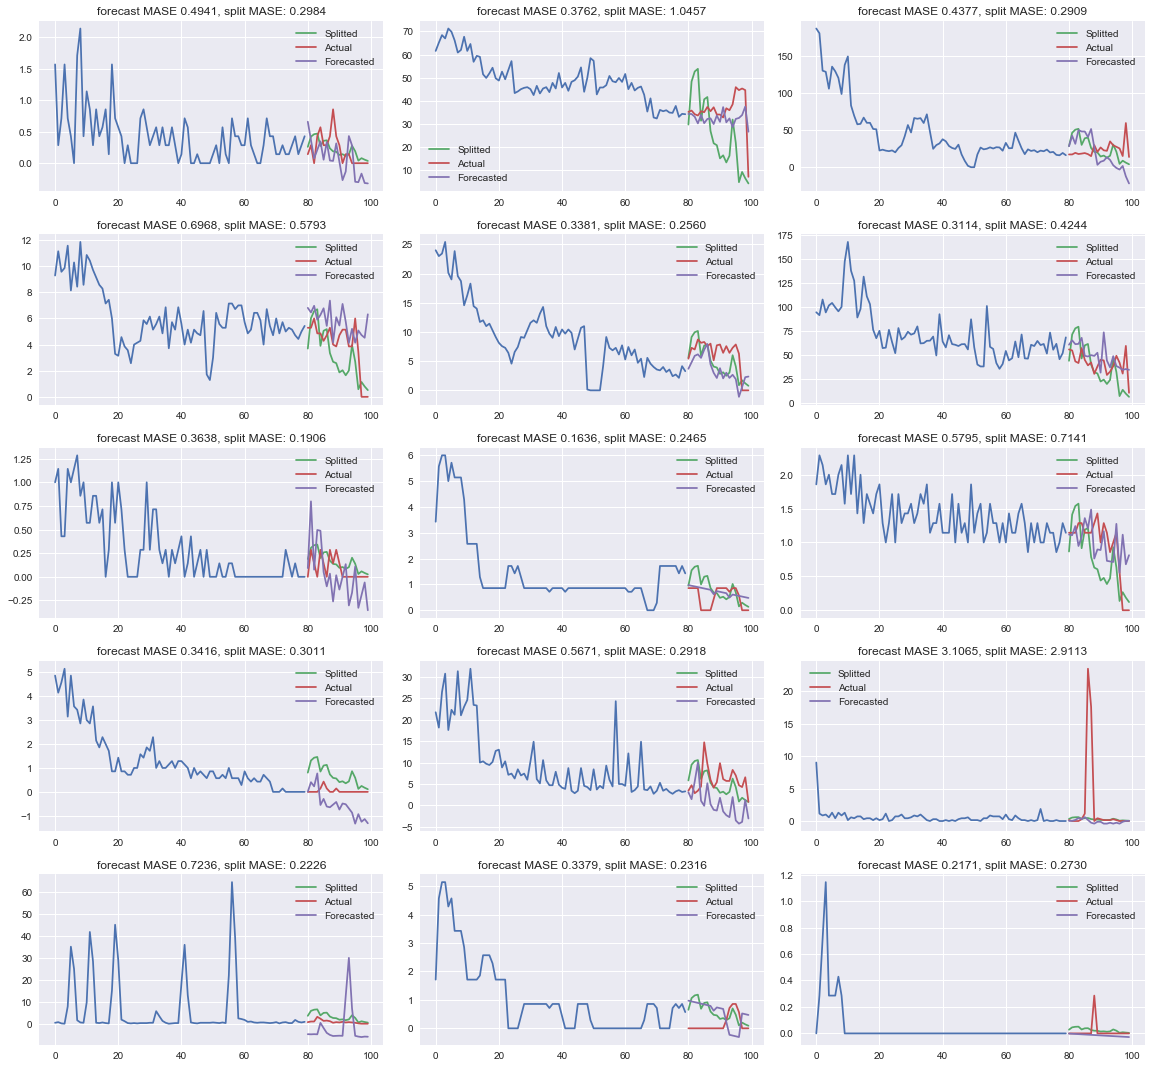

In [41]:
cluster = 99

splits = series[series["Cluster"]==cluster]
c_serie = group_series.loc[cluster].values
c_pred = forecast.loc[cluster].values
n_splits = splits.shape[0]

split_MASE= []
forecast_MASE= []


rows = 5 #n_splits/3.0+1
plt.figure(figsize=(16,3*rows))


takes = np.random.randint(n_splits,size = 3*rows+1)
keep_splits = list(splits.index[takes])

i=1
for index,split in splits.iterrows():
    serie = split.values[1:]
    weighted = serie[:-fc].sum()/c_serie[:-fc].sum()
    pred = c_pred * weighted

    fcst,m = grid_forecast(serie,seasonality,fc)

    train_series = np.ravel(serie[:-fc])
    
    split_mase = hw.MASE(train_series,serie[-fc:],pred,m)
    fcst_mase = hw.MASE(train_series,serie[-fc:],fcst,m)
    
    split_MASE.append(split_mase)
    forecast_MASE.append(fcst_mase)
    
    if index not in keep_splits: continue
    plt.subplot(rows,3,i)
    plt.title("forecast MASE %.04f, split MASE: %.04f"%(fcst_mase,split_mase))
    plt.plot(range(0,l-fc),serie[:-fc],label=None)
    plt.plot(range(l-fc,l),pred,label="Splitted")        
    plt.plot(range(l-fc,l),serie[-fc:],label="Actual")
    plt.plot(range(l-fc,l),fcst,label="Forecasted")
    plt.legend()
    i+=1

agg = MASE[cluster-1]
split = np.array(split_MASE).mean()
fcst = np.array(forecast_MASE).mean()
increase = (split-agg)/(agg)
accuracy = (split-fcst)/(fcst)

print("Cluster %d split:%.2f , agg:%.2f *** Increase %.2f %%"%(cluster,split,agg,increase*100))
plt.tight_layout()
plt.show()

## Seasonal Decompose

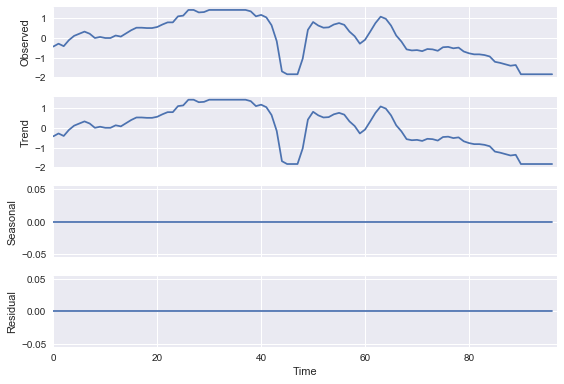

In [51]:
import statsmodels.api as sm

serie = series.iloc[5].values[1:]

res = sm.tsa.seasonal_decompose(s,freq=1,model='a')
resplot = res.plot()
plt.show()


### ARIMA Models

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import autocorrelation_plot





l=20
s = product_df_full.loc[l].values[2:].astype(float)

# product_df_full.loc[l,product_df_full.columns[1:]].plot(kind='kde')
# plt.show()

# model = ARIMA(s, order=(0, 2, 2))
# results_ARIMA = model.fit(disp=-1, trend='nc',method = 'css-mle')#start_params=(2,2)   

# dim = X_z.shape[1]
# new_dim = results_ARIMA.fittedvalues.shape[0]


plt.figure(figsize=(16,150))
for cluster,serie in group_series.iterrows():
    #winsorizing series
    serie = pd.DataFrame(serie).apply(mstats.winsorize,limits = (None,0.075)).values  
    #days to forecast
    fc=20
    l=len(serie) 

    pred,m = grid_forecast(serie,seasonality,fc)

    rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(serie[-fc:], pred)]) / fc)
    
    train_series = np.ravel(serie[:-fc])
    mase = hw.MASE(train_series,serie[-fc:],pred,1)
    
    if mase<1.2: continue
    plt.subplot(40,3,cluster)
    plt.title("M = %d, MASE: %.15f"%(m,mase))
    plt.plot(range(0,l-fc),serie[:-fc])
    plt.plot(range(l-fc,l),pred,label="Predicted")
    plt.plot(range(l-fc,l),serie[-fc:],label="Actual")
    plt.legend()


plt.show()




